### Time series forecasting using LSTMs

Using a simple univariate time series on monthly milk production data from https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
milk = pd.read_csv('./data/monthly-milk-production-pounds-p.csv')

In [3]:
# clean data
milk = milk.iloc[0:-1]
milk.columns = ['t', 'milk']
milk['t'] = pd.to_datetime(milk['t'])

In [4]:
def fill_time_series(df, ts_col, freq):
    min_time = min(df[ts_col])
    max_time = max(df[ts_col])
    dt_idx = pd.date_range(min_time, max_time, freq=freq)
    df.index = df[ts_col]
    df = df.reindex(dt_idx)
    return df

In [5]:
milk = fill_time_series(milk, 't', 'MS')

In [6]:
milk.head()

,t,milk
1962-01-01,1962-01-01,589.0
1962-02-01,1962-02-01,561.0
1962-03-01,1962-03-01,640.0
1962-04-01,1962-04-01,656.0
1962-05-01,1962-05-01,727.0


In [7]:
milk.describe()

,milk
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [8]:
milk = milk.reset_index(drop=True)
milk.to_csv('./data/milk-clean.csv', header=True, index=False)

In [9]:
# define start of test set
test_start_date = '1973-01-01'

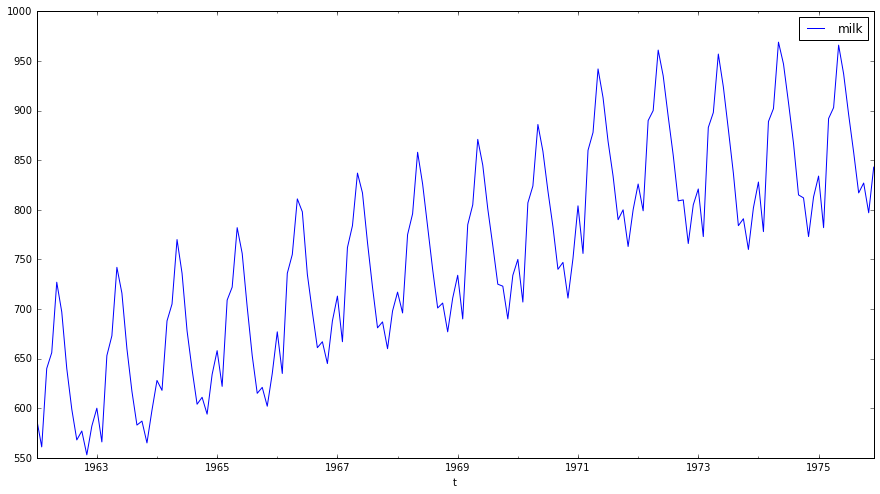

In [10]:
milk.plot(x='t',y='milk', figsize=(15,8))

Make data stationary by taking the difference between each value of the time series and it's previous value

In [11]:
milk['milk_stat'] = milk['milk'] - milk['milk'].shift(1)

In [12]:
milk = milk.dropna(how='any')

In [13]:
milk.head()

,t,milk,milk_stat
1,1962-02-01,561.0,-28.0
2,1962-03-01,640.0,79.0
3,1962-04-01,656.0,16.0
4,1962-05-01,727.0,71.0
5,1962-06-01,697.0,-30.0


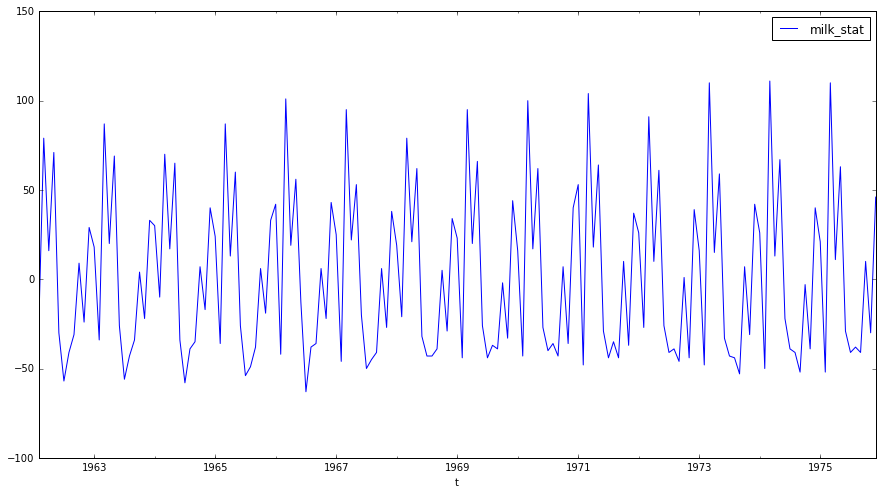

In [14]:
milk.plot(x='t',y='milk_stat', figsize=(15,8))

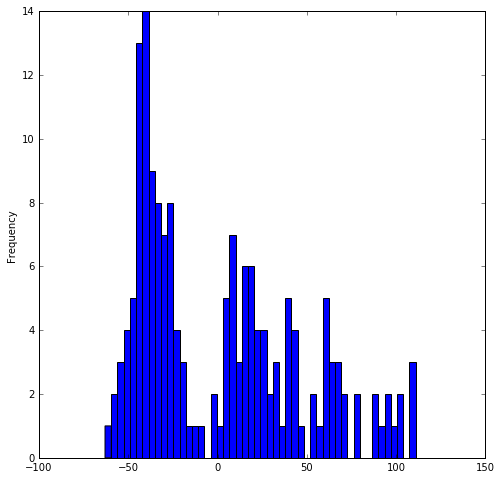

In [15]:
milk.milk_stat.plot.hist(bins=50, figsize=(8, 8))

### Univariate time series

Train a forecasting model that predicts the next value in the time series, given the previous 24 values

Fit data scaler on training set

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
def scale_series(series, scaler=None):
    
    vals = series.values
    vals = vals.reshape(-1, 1)

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(vals)

    return scaler.transform(vals), scaler

In [18]:
train = milk.copy()
train = train[train.t<test_start_date]

scaled_vals, minmaxscaler = scale_series(train['milk_stat'])

train['target'] = scaled_vals

In [19]:
train.head()

,t,milk,milk_stat,target
1,1962-02-01,561.0,-28.0,0.209581
2,1962-03-01,640.0,79.0,0.850299
3,1962-04-01,656.0,16.0,0.473054
4,1962-05-01,727.0,71.0,0.802395
5,1962-06-01,697.0,-30.0,0.197605


In [20]:
train = train[['target']]

Define time steps window

In [21]:
W = 24

In [22]:
for t in range(1, W+1):
    train['target_t-'+str(t)] = train['target'].shift(t)

In [23]:
train.head()

,target,target_t-1,target_t-2,target_t-3,target_t-4,target_t-5,target_t-6,target_t-7,target_t-8,target_t-9,...,target_t-15,target_t-16,target_t-17,target_t-18,target_t-19,target_t-20,target_t-21,target_t-22,target_t-23,target_t-24
1,0.209581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.850299,0.209581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.473054,0.850299,0.209581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.802395,0.473054,0.850299,0.209581,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.197605,0.802395,0.473054,0.850299,0.209581,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# drop records with NaN
train = train.dropna(how='any')

In [25]:
y = train['target'].values

In [26]:
y.shape

(107,)

In [27]:
y[:5]

array([ 0.31736527,  0.79640719,  0.47904192,  0.76646707,  0.17365269])

In [28]:
X = train.drop('target', axis=1).as_matrix()

In [29]:
X = X.reshape(X.shape[0], W, 1)

Input shape is (samples, time steps, features)

In [30]:
X.shape

(107, 24, 1)

First training example:

In [31]:
X[0,:,:]

array([[ 0.55688623],
       [ 0.5748503 ],
       [ 0.24550898],
       [ 0.4011976 ],
       [ 0.17365269],
       [ 0.11976048],
       [ 0.04191617],
       [ 0.22155689],
       [ 0.79041916],
       [ 0.49700599],
       [ 0.89820359],
       [ 0.17365269],
       [ 0.48502994],
       [ 0.5508982 ],
       [ 0.23353293],
       [ 0.43113772],
       [ 0.19161677],
       [ 0.13173653],
       [ 0.03592814],
       [ 0.19760479],
       [ 0.80239521],
       [ 0.47305389],
       [ 0.8502994 ],
       [ 0.20958084]])

In [32]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Input, Concatenate, Activation

Using TensorFlow backend.


In [33]:
model = Sequential()

In [34]:
model.add(LSTM(2, input_shape=(W, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

In [35]:
model.compile(optimizer='adam', loss='mse')

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X, y, batch_size=24, epochs=500, shuffle=False, verbose=2)

Epoch 1/500
 - 1s - loss: 0.3089
Epoch 2/500
 - 0s - loss: 0.2902
Epoch 3/500
 - 0s - loss: 0.2723
Epoch 4/500
 - 0s - loss: 0.2558
Epoch 5/500
 - 0s - loss: 0.2406
Epoch 6/500
 - 0s - loss: 0.2266
Epoch 7/500
 - 0s - loss: 0.2137
Epoch 8/500
 - 0s - loss: 0.2017
Epoch 9/500
 - 0s - loss: 0.1904
Epoch 10/500
 - 0s - loss: 0.1797
Epoch 11/500
 - 0s - loss: 0.1695
Epoch 12/500
 - 0s - loss: 0.1598
Epoch 13/500
 - 0s - loss: 0.1504
Epoch 14/500
 - 0s - loss: 0.1415
Epoch 15/500
 - 0s - loss: 0.1331
Epoch 16/500
 - 0s - loss: 0.1252
Epoch 17/500
 - 0s - loss: 0.1179
Epoch 18/500
 - 0s - loss: 0.1112
Epoch 19/500
 - 0s - loss: 0.1052
Epoch 20/500
 - 0s - loss: 0.1000
Epoch 21/500
 - 0s - loss: 0.0956
Epoch 22/500
 - 0s - loss: 0.0919
Epoch 23/500
 - 0s - loss: 0.0889
Epoch 24/500
 - 0s - loss: 0.0866
Epoch 25/500
 - 0s - loss: 0.0848
Epoch 26/500
 - 0s - loss: 0.0834
Epoch 27/500
 - 0s - loss: 0.0824
Epoch 28/500
 - 0s - loss: 0.0817
Epoch 29/500
 - 0s - loss: 0.0811
Epoch 30/500
 - 0s - lo

 - 0s - loss: 0.0467
Epoch 239/500
 - 0s - loss: 0.0465
Epoch 240/500
 - 0s - loss: 0.0463
Epoch 241/500
 - 0s - loss: 0.0461
Epoch 242/500
 - 0s - loss: 0.0459
Epoch 243/500
 - 0s - loss: 0.0456
Epoch 244/500
 - 0s - loss: 0.0454
Epoch 245/500
 - 0s - loss: 0.0452
Epoch 246/500
 - 0s - loss: 0.0450
Epoch 247/500
 - 0s - loss: 0.0448
Epoch 248/500
 - 0s - loss: 0.0446
Epoch 249/500
 - 0s - loss: 0.0444
Epoch 250/500
 - 0s - loss: 0.0442
Epoch 251/500
 - 0s - loss: 0.0439
Epoch 252/500
 - 0s - loss: 0.0437
Epoch 253/500
 - 0s - loss: 0.0435
Epoch 254/500
 - 0s - loss: 0.0433
Epoch 255/500
 - 0s - loss: 0.0431
Epoch 256/500
 - 0s - loss: 0.0428
Epoch 257/500
 - 0s - loss: 0.0426
Epoch 258/500
 - 0s - loss: 0.0424
Epoch 259/500
 - 0s - loss: 0.0422
Epoch 260/500
 - 0s - loss: 0.0419
Epoch 261/500
 - 0s - loss: 0.0417
Epoch 262/500
 - 0s - loss: 0.0415
Epoch 263/500
 - 0s - loss: 0.0412
Epoch 264/500
 - 0s - loss: 0.0410
Epoch 265/500
 - 0s - loss: 0.0408
Epoch 266/500
 - 0s - loss: 0.0405

Epoch 473/500
 - 0s - loss: 0.0066
Epoch 474/500
 - 0s - loss: 0.0065
Epoch 475/500
 - 0s - loss: 0.0065
Epoch 476/500
 - 0s - loss: 0.0064
Epoch 477/500
 - 0s - loss: 0.0063
Epoch 478/500
 - 0s - loss: 0.0063
Epoch 479/500
 - 0s - loss: 0.0062
Epoch 480/500
 - 0s - loss: 0.0062
Epoch 481/500
 - 0s - loss: 0.0061
Epoch 482/500
 - 0s - loss: 0.0061
Epoch 483/500
 - 0s - loss: 0.0060
Epoch 484/500
 - 0s - loss: 0.0060
Epoch 485/500
 - 0s - loss: 0.0059
Epoch 486/500
 - 0s - loss: 0.0059
Epoch 487/500
 - 0s - loss: 0.0058
Epoch 488/500
 - 0s - loss: 0.0058
Epoch 489/500
 - 0s - loss: 0.0057
Epoch 490/500
 - 0s - loss: 0.0057
Epoch 491/500
 - 0s - loss: 0.0057
Epoch 492/500
 - 0s - loss: 0.0056
Epoch 493/500
 - 0s - loss: 0.0056
Epoch 494/500
 - 0s - loss: 0.0055
Epoch 495/500
 - 0s - loss: 0.0055
Epoch 496/500
 - 0s - loss: 0.0054
Epoch 497/500
 - 0s - loss: 0.0054
Epoch 498/500
 - 0s - loss: 0.0054
Epoch 499/500
 - 0s - loss: 0.0053
Epoch 500/500
 - 0s - loss: 0.0053


Prepare test for scoring

In [38]:
test = milk.copy()

scaled_vals, _ = scale_series(test['milk_stat'])
test['target'] = scaled_vals
test = test[['t', 'target']]

for t in range(1, W+1):
    test['target_t-'+str(t)] = test['target'].shift(t)
    
test = test.dropna(how='any')
test = test[test.t>=test_start_date]

test_y = test.target.values

test_X = test.drop(['t', 'target'], axis=1).as_matrix()

test_X = test_X.reshape(test_X.shape[0], W, 1)

In [39]:
test_X.shape

(36, 24, 1)

In [40]:
preds = model.predict(test_X)

Evaluate model

In [41]:
eval_df = test.copy()
eval_df = eval_df[['t', 'target']]
eval_df['preds'] = preds

In [42]:
eval_df.head()

,t,target,preds
132,1973-01-01,0.454023,0.688952
133,1973-02-01,0.086207,0.056970
134,1973-03-01,0.994253,0.895781
135,1973-04-01,0.448276,0.406769
136,1973-05-01,0.701149,0.674742


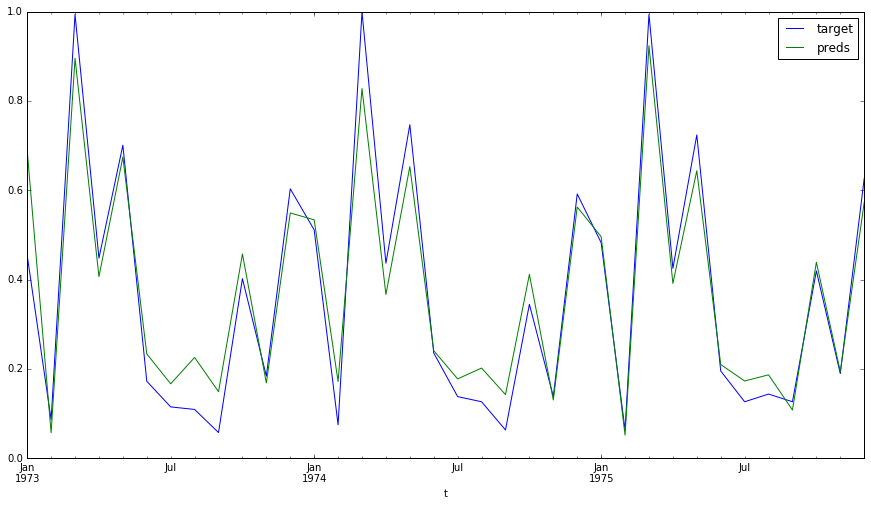

In [43]:
eval_df.plot(x='t', figsize=(15,8))

In [44]:
model.evaluate(test_X, test_y)

36/36 [==============================] - 0s 2ms/step


0.0054321323469695114

### Time series with additional features

Create a disease event, known before the month being predicted. Disease events reduce milk production by 25%

In [47]:
milk['disease'] = 0
test_start_idx = milk[milk.t==test_start_date].index.values
np.random.seed(0)
# 8 disease events in train set
milk.loc[np.random.randint(0, test_start_idx-1, 8), 'disease'] = 1
# 3 disease events in test set
milk.loc[np.random.randint(test_start_idx, milk.shape[0]-1, 3), 'disease'] = 1
# milk production reduces by 25% during disease events
milk['milk_disease'] = np.where(milk['disease']==0, milk['milk'], milk['milk']*0.75)

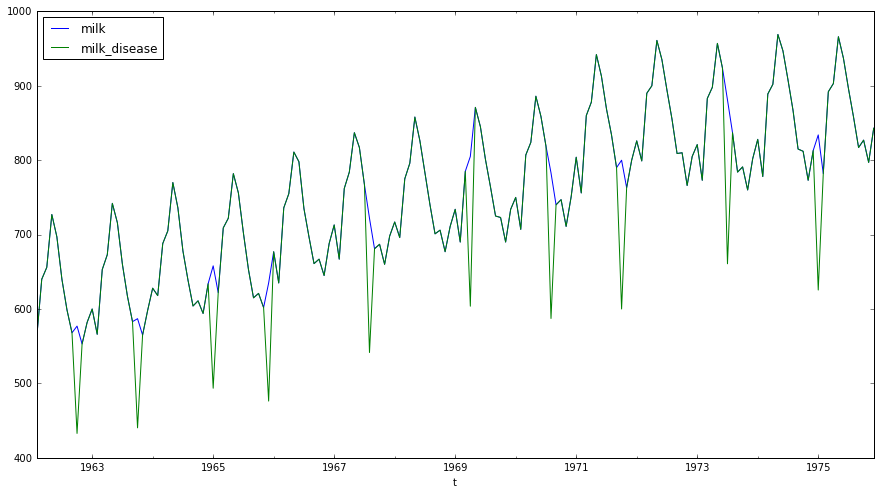

In [48]:
milk.plot(x='t',y=['milk', 'milk_disease'], figsize=(15,8))

In [49]:
milk['milk_disease_stat'] = milk['milk_disease'] - milk['milk_disease'].shift(1)

In [50]:
milk = milk.dropna(how='any')

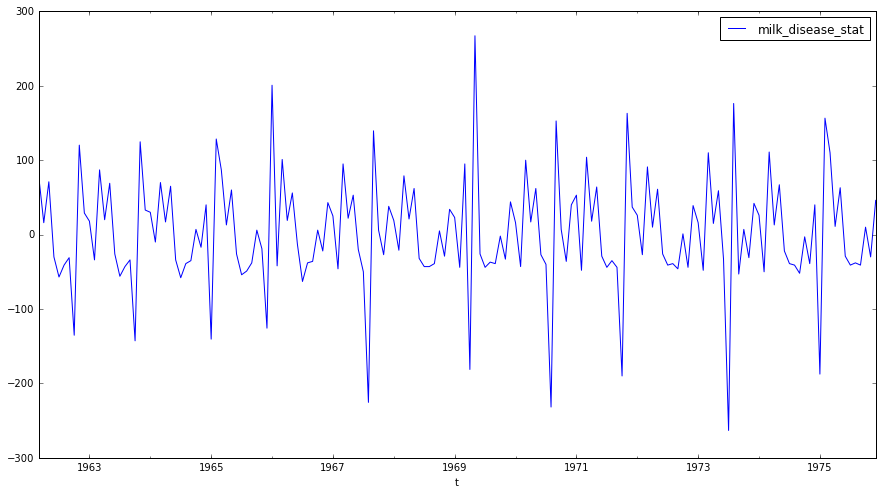

In [51]:
milk.plot(x='t', y='milk_disease_stat', figsize=(15, 8))

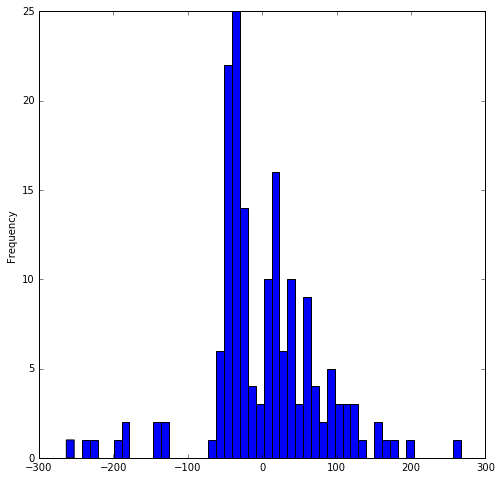

In [52]:
milk.milk_disease_stat.plot.hist(bins=50, figsize=(8, 8))

In [53]:
train = milk.copy()
train = train[train.t<test_start_date]

scaled_vals, minmaxscaler = scale_series(train['milk_disease_stat'])

train['target'] = scaled_vals

In [54]:
train.head()

,t,milk,milk_stat,disease,milk_disease,milk_disease_stat,target
2,1962-03-01,640.0,79.0,0,640.0,79.0,0.622745
3,1962-04-01,656.0,16.0,0,656.0,16.0,0.496493
4,1962-05-01,727.0,71.0,0,727.0,71.0,0.606713
5,1962-06-01,697.0,-30.0,0,697.0,-30.0,0.404309
6,1962-07-01,640.0,-57.0,0,640.0,-57.0,0.350200


Prepare normalized data for model

In [55]:
train = train[['target', 'disease']]

Define time steps window

In [56]:
W = 24

In [57]:
for t in range(1, W+1):
    train['target_t-'+str(t)] = train['target'].shift(t)

In [58]:
train.head()

,target,disease,target_t-1,target_t-2,target_t-3,target_t-4,target_t-5,target_t-6,target_t-7,target_t-8,...,target_t-15,target_t-16,target_t-17,target_t-18,target_t-19,target_t-20,target_t-21,target_t-22,target_t-23,target_t-24
2,0.622745,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.496493,0,0.622745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.606713,0,0.496493,0.622745,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.404309,0,0.606713,0.496493,0.622745,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.350200,0,0.404309,0.606713,0.496493,0.622745,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# drop records with NaN
train = train.dropna(how='any')

In [60]:
y = train['target'].values

In [61]:
y.shape

(106,)

In [62]:
y[:5]

array([ 0.60470942,  0.49849699,  0.59468938,  0.39629259,  0.34819639])

Create 2 sets of input features, one for the time series sequence (window 24), and the other the categorical feature representing disease events

In [65]:
X_sequence = train.drop(labels=['target', 'disease'], axis=1).as_matrix()

In [66]:
X_sequence = X_sequence.reshape(X_sequence.shape[0], W, 1)

In [67]:
X_sequence.shape

(106, 24, 1)

First 2 X_sequence training examples

In [68]:
X_sequence[:2,:,:]

array([[[ 0.44438878],
        [ 0.5245491 ],
        [ 0.53056112],
        [ 0.71442886],
        [ 0.17835671],
        [ 0.39629259],
        [ 0.37825651],
        [ 0.35220441],
        [ 0.41232465],
        [ 0.60270541],
        [ 0.50450902],
        [ 0.63877756],
        [ 0.39629259],
        [ 0.500501  ],
        [ 0.52254509],
        [ 0.70541082],
        [ 0.19338677],
        [ 0.40230461],
        [ 0.38226453],
        [ 0.3502004 ],
        [ 0.40430862],
        [ 0.60671343],
        [ 0.49649299],
        [ 0.62274549]],

       [[ 0.60470942],
        [ 0.44438878],
        [ 0.5245491 ],
        [ 0.53056112],
        [ 0.71442886],
        [ 0.17835671],
        [ 0.39629259],
        [ 0.37825651],
        [ 0.35220441],
        [ 0.41232465],
        [ 0.60270541],
        [ 0.50450902],
        [ 0.63877756],
        [ 0.39629259],
        [ 0.500501  ],
        [ 0.52254509],
        [ 0.70541082],
        [ 0.19338677],
        [ 0.40230461],
        [

In [69]:
X_features = train['disease']

First 2 X_features training examples

In [70]:
X_features[:2]

26    0
27    0
Name: disease, dtype: int64

In [71]:
X_features.shape

(106,)

In [72]:
# specify LSTM layer and it's sequential input
input_sequence = Input(shape=(W, 1))

seq_layer = LSTM(2)(input_sequence)

In [73]:
# specify dense layer with sigmoid activation and it's categorical input
input_features = Input(shape=(1,))

feat_layer = Dense(1, activation='relu')(input_features)

In [74]:
# combine input dense and LSTM layers
combined = Concatenate()([seq_layer, feat_layer])

In [75]:
# stack some fully connected layers on top, finishing with an output layer with linear activation to actually make the prediction
dense1 = Dense(50, activation='relu')(combined)
dense2 = Dense(50, activation='relu')(dense1)

output = Dense(1, activation='linear')(dense2)

In [76]:
model = Model(inputs=[input_sequence, input_features], outputs=output)

In [77]:
model.compile(optimizer='adam', loss='mse')

In [78]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 2)            32          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            2           input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [79]:
model.fit(x=[X_sequence, X_features], y=y, batch_size=24, epochs=500, verbose=2)

Epoch 1/500
 - 1s - loss: 0.2009
Epoch 2/500
 - 0s - loss: 0.1544
Epoch 3/500
 - 0s - loss: 0.1148
Epoch 4/500
 - 0s - loss: 0.0814
Epoch 5/500
 - 0s - loss: 0.0541
Epoch 6/500
 - 0s - loss: 0.0345
Epoch 7/500
 - 0s - loss: 0.0238
Epoch 8/500
 - 0s - loss: 0.0202
Epoch 9/500
 - 0s - loss: 0.0199
Epoch 10/500
 - 0s - loss: 0.0198
Epoch 11/500
 - 0s - loss: 0.0189
Epoch 12/500
 - 0s - loss: 0.0181
Epoch 13/500
 - 0s - loss: 0.0178
Epoch 14/500
 - 0s - loss: 0.0175
Epoch 15/500
 - 0s - loss: 0.0171
Epoch 16/500
 - 0s - loss: 0.0167
Epoch 17/500
 - 0s - loss: 0.0164
Epoch 18/500
 - 0s - loss: 0.0159
Epoch 19/500
 - 0s - loss: 0.0154
Epoch 20/500
 - 0s - loss: 0.0151
Epoch 21/500
 - 0s - loss: 0.0148
Epoch 22/500
 - 0s - loss: 0.0143
Epoch 23/500
 - 0s - loss: 0.0142
Epoch 24/500
 - 0s - loss: 0.0142
Epoch 25/500
 - 0s - loss: 0.0138
Epoch 26/500
 - 0s - loss: 0.0139
Epoch 27/500
 - 0s - loss: 0.0137
Epoch 28/500
 - 0s - loss: 0.0138
Epoch 29/500
 - 0s - loss: 0.0139
Epoch 30/500
 - 0s - lo

 - 0s - loss: 0.0116
Epoch 239/500
 - 0s - loss: 0.0117
Epoch 240/500
 - 0s - loss: 0.0117
Epoch 241/500
 - 0s - loss: 0.0117
Epoch 242/500
 - 0s - loss: 0.0116
Epoch 243/500
 - 0s - loss: 0.0116
Epoch 244/500
 - 0s - loss: 0.0116
Epoch 245/500
 - 0s - loss: 0.0118
Epoch 246/500
 - 0s - loss: 0.0117
Epoch 247/500
 - 0s - loss: 0.0117
Epoch 248/500
 - 0s - loss: 0.0118
Epoch 249/500
 - 0s - loss: 0.0122
Epoch 250/500
 - 0s - loss: 0.0118
Epoch 251/500
 - 0s - loss: 0.0118
Epoch 252/500
 - 0s - loss: 0.0115
Epoch 253/500
 - 0s - loss: 0.0119
Epoch 254/500
 - 0s - loss: 0.0118
Epoch 255/500
 - 0s - loss: 0.0116
Epoch 256/500
 - 0s - loss: 0.0119
Epoch 257/500
 - 0s - loss: 0.0118
Epoch 258/500
 - 0s - loss: 0.0115
Epoch 259/500
 - 0s - loss: 0.0117
Epoch 260/500
 - 0s - loss: 0.0115
Epoch 261/500
 - 0s - loss: 0.0115
Epoch 262/500
 - 0s - loss: 0.0114
Epoch 263/500
 - 0s - loss: 0.0115
Epoch 264/500
 - 0s - loss: 0.0115
Epoch 265/500
 - 0s - loss: 0.0114
Epoch 266/500
 - 0s - loss: 0.0115

Epoch 473/500
 - 0s - loss: 0.0109
Epoch 474/500
 - 0s - loss: 0.0108
Epoch 475/500
 - 0s - loss: 0.0106
Epoch 476/500
 - 0s - loss: 0.0110
Epoch 477/500
 - 0s - loss: 0.0108
Epoch 478/500
 - 0s - loss: 0.0108
Epoch 479/500
 - 0s - loss: 0.0106
Epoch 480/500
 - 0s - loss: 0.0108
Epoch 481/500
 - 0s - loss: 0.0108
Epoch 482/500
 - 0s - loss: 0.0106
Epoch 483/500
 - 0s - loss: 0.0108
Epoch 484/500
 - 0s - loss: 0.0105
Epoch 485/500
 - 0s - loss: 0.0109
Epoch 486/500
 - 0s - loss: 0.0106
Epoch 487/500
 - 0s - loss: 0.0108
Epoch 488/500
 - 0s - loss: 0.0106
Epoch 489/500
 - 0s - loss: 0.0106
Epoch 490/500
 - 0s - loss: 0.0106
Epoch 491/500
 - 0s - loss: 0.0106
Epoch 492/500
 - 0s - loss: 0.0108
Epoch 493/500
 - 0s - loss: 0.0105
Epoch 494/500
 - 0s - loss: 0.0108
Epoch 495/500
 - 0s - loss: 0.0112
Epoch 496/500
 - 0s - loss: 0.0104
Epoch 497/500
 - 0s - loss: 0.0109
Epoch 498/500
 - 0s - loss: 0.0105
Epoch 499/500
 - 0s - loss: 0.0108
Epoch 500/500
 - 0s - loss: 0.0104


Prepare data for scoring

In [80]:
test = milk.copy()

scaled_vals, _ = scale_series(test['milk_disease_stat'])
test['target'] = scaled_vals
test = test[['t', 'target', 'disease']]

for t in range(1, W+1):
    test['target_t-'+str(t)] = test['target'].shift(t)
    
test = test.dropna(how='any')
test = test[test.t>=test_start_date]

test_y = test.target.values

test_X_features = test['disease']
test_X_sequence = test.drop(['t', 'target', 'disease'], axis=1).as_matrix()

test_X_sequence = test_X.reshape(test_X.shape[0], W, 1)

In [81]:
test_X_features.shape

(36,)

In [82]:
test_X_sequence.shape

(36, 24, 1)

In [83]:
preds = model.predict([test_X_sequence, test_X_features])

In [84]:
eval_df = test.copy()
eval_df = eval_df[['t', 'target']]
eval_df['preds'] = preds

In [85]:
eval_df.head()

,t,target,preds
132,1973-01-01,0.526390,0.544114
133,1973-02-01,0.405749,0.476857
134,1973-03-01,0.703582,0.550315
135,1973-04-01,0.524505,0.521712
136,1973-05-01,0.607446,0.504965


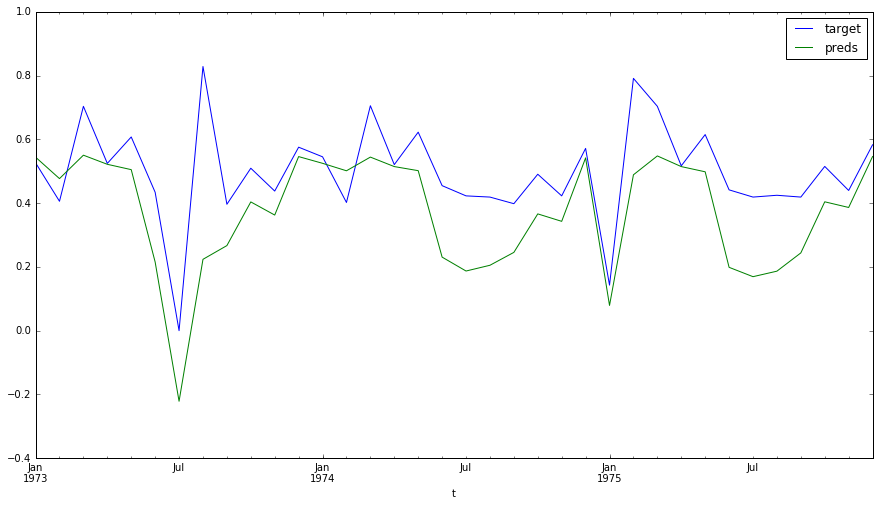

In [86]:
eval_df.plot(x='t', figsize=(15,8))

In [87]:
model.evaluate([test_X_sequence, test_X_features], test_y)

36/36 [==============================] - 0s 3ms/step


0.031762762926518917